# Goal:

to look at user purchase history and create categories of items that
are likely to be bought together and, therefore, should belong to the same section.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import numpy as np
import random
import networkx as nx  
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from functools import reduce

In [2]:
purchase = pd.read_csv('../DS-Take-Home-master/9.grocery cluster/purchase_history.csv')
item = pd.read_csv('../DS-Take-Home-master/9.grocery cluster/item_to_id.csv')

In [3]:
purchase.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [4]:
item.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [5]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [6]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [7]:
purch_time = purchase.groupby('user_id')['id'].count().reset_index(name = 'PURCH TIMES').groupby('PURCH TIMES')['PURCH TIMES'].count().reset_index(name = 'Freq')

In [8]:
purch_time.head()

,PURCH TIMES,Freq
0,1,14496
1,2,7155
2,3,2458
3,4,618
4,5,130


Text(0.5, 1.0, 'The distribution of Purchase Times')

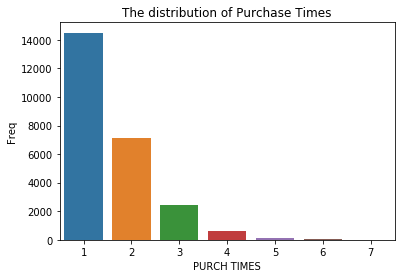

In [9]:
sns.barplot(x = 'PURCH TIMES', y ='Freq', data = purch_time).set_title('The distribution of Purchase Times')

## we can see from this chart, most customers only bought 1 or 2 times at this grocery store.

In [10]:
# we would like to set order id so that when we explode the id column we can identify which order it is in
purchase['order_id'] = purchase.groupby(['user_id'])['user_id'].cumcount()+1
purchase.head()

,user_id,id,order_id
0,222087,"27,26",1
1,1343649,"6,47,17",1
2,404134,"18,12,23,22,27,43,38,20,35,1",1
3,1110200,"9,23,2,20,26,47,37",1
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...",1


In [11]:
# explode id column
purchase = purchase.set_index(['user_id','order_id']).apply(lambda x: x.str.split(',').explode()).reset_index()
purchase.head()

,user_id,order_id,id
0,222087,1,27
1,222087,1,26
2,1343649,1,6
3,1343649,1,47
4,1343649,1,17


In [12]:
pivot_table = purchase.groupby(['user_id','order_id','id'])['id'].count().unstack().reset_index().fillna(0)
pivot_table.head()

id,user_id,order_id,1,10,11,12,13,14,15,16,...,44,45,46,47,48,5,6,7,8,9
0,47,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,113,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,123,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,223,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
dic = dict(zip(item.Item_id,item.Item_name))

In [14]:
column_list = pivot_table.columns[2:].astype('int').to_list() 
str_column = ['user_id','order_id']+[dic[i] for i in column_list] 
pivot_table.columns = str_column

In [15]:
pivot_table.head()

,user_id,order_id,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,...,broccoli,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda
0,47,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,113,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,123,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,223,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
pivot_table.head()

,user_id,order_id,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,...,broccoli,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda
0,47,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,113,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,123,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,223,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# set columns' value to be int
pivot_table.iloc[:,2:] = pivot_table.iloc[:,2:].astype('int64')
pivot_table.head()

,user_id,order_id,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,...,broccoli,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda
0,47,1,0,0,0,0,1,0,1,1,...,1,1,1,0,0,0,0,0,0,0
1,68,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,113,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,123,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,223,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


# the customer who bought the most items overall in her lifetime


In [18]:
pivot_table['qty'] = pivot_table.iloc[:,2:].sum(axis = 1)
pivot_table.head()

,user_id,order_id,sugar,carrots,cereals,shampoo,bagels,eggs,aluminum foil,milk,...,cauliflower,bananas,pork,yogurt,waffles,poultry,sandwich bags,butter,soda,qty
0,47,1,0,0,0,0,1,0,1,1,...,1,1,0,0,0,0,0,0,0,13
1,68,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,8
2,113,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,11
3,123,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,223,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,7


In [19]:
tot_qty_per_cust = pivot_table.groupby('user_id')['qty'].sum().reset_index(name='TOT QTY')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

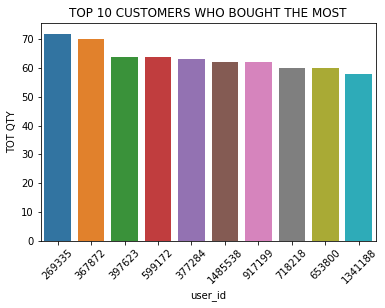

In [20]:
top_10 = tot_qty_per_cust.sort_values(by = 'TOT QTY',ascending = False).head(10)

sns.barplot(x = 'user_id', y = 'TOT QTY', data =top_10 , order  = top_10.user_id).set_title('TOP 10 CUSTOMERS WHO BOUGHT THE MOST')
plt.xticks(rotation = 45)


## we can see user_id - 269335 has bought the most items and it is 144

# Q2: for each item, the customer who bought that product the most

In [21]:
# for each item, get the customer bought times.
items = purchase.groupby(['id','user_id'])['user_id'].count().reset_index(name = 'times')
items.head()

,id,user_id,times
0,1,223,1
1,1,323,1
2,1,394,1
3,1,453,1
4,1,553,1


In [22]:
items_max = items.loc[items.groupby(['id'])['times'].transform(max)==items.times]


In [23]:
items_max.head(20)

,id,user_id,times
171,1,31625,4
369,1,68836,4
2913,1,540483,4
5920,1,1091637,4
7021,1,1301034,4
11453,10,618914,4
12105,10,743501,4
15948,10,1485538,4
16689,11,367872,3
16997,11,534745,3


## we can see that more than one customer reach the most purchase on per item.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

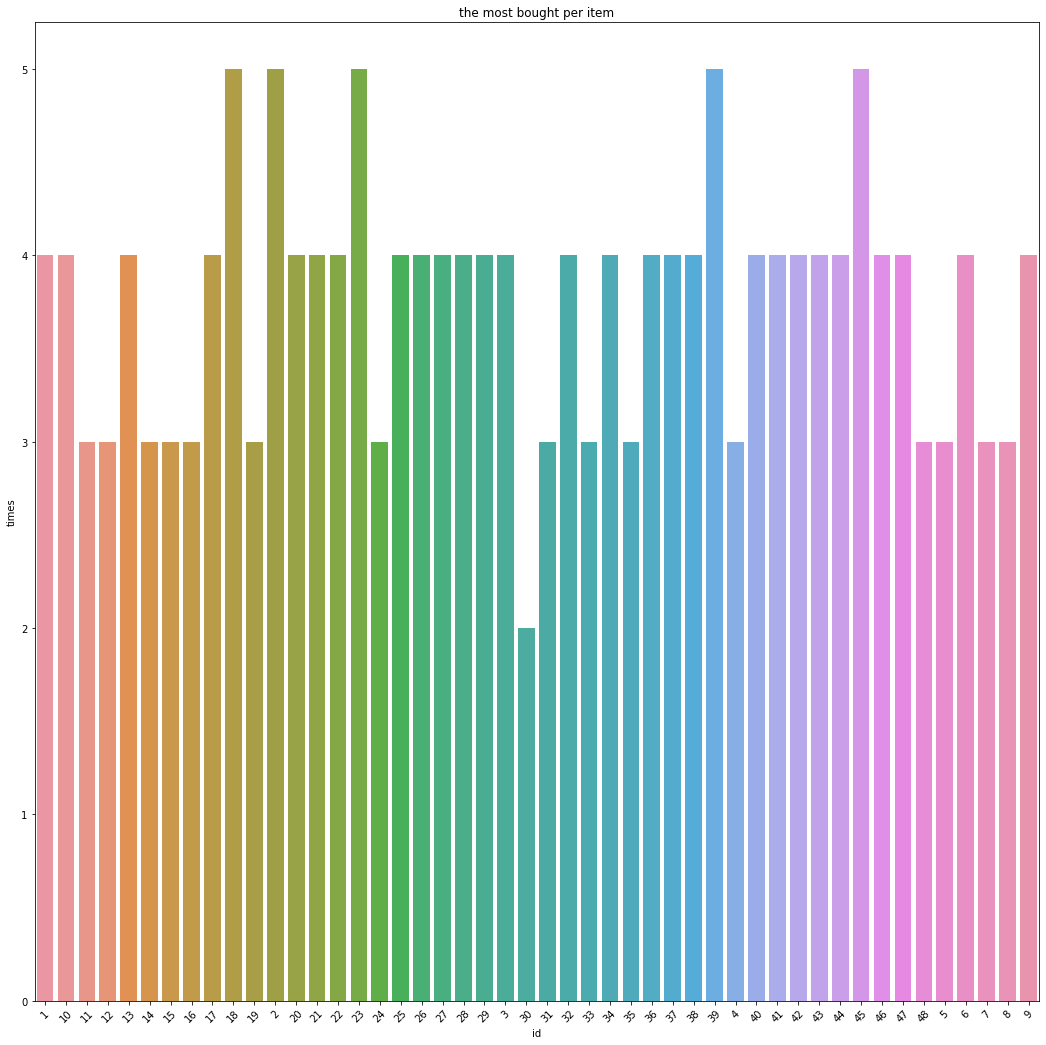

In [24]:
plt.figure(figsize = (18,18))
sns.barplot(x = 'id', y ='times',data = items_max).set_title('the most bought per item')
plt.xticks(rotation = 45)

## we can see that, for most item their most customer's purchase time  are 3 or 4 times.

## we may want to see the top 10 items that have been bought the most

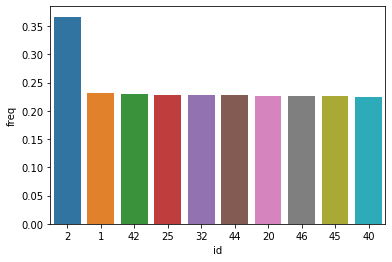

In [25]:
orders = pivot_table.shape[0] # numbers of order
most_items = items.groupby('id')['times'].sum().reset_index(name = 'qty').sort_values('qty',ascending = False).head(10)
most_items['freq'] = most_items['qty']/orders
sns.barplot(x = 'id', y = 'freq',data= most_items, order = most_items.id)

## item 2 is the most popular product in the grocery store. And its frequency is around 0.35. (for example, the most frequent item occurs in only around 35% of transactions).

## By setting a support threshold of 0.01 and confidence of 0.5, 
we can run the Apriori algorithm and obtain a set of 5,668 results. 
These threshold values are chosen so that the number of rules returned is
high, but this number would reduce if we increased either threshold. We would recommend experimenting with these thresholds to obtain the most appropriate values. Whilst there are too many rules to be able to look at them all individually, we can look at the five rules with the largest lift:



In [26]:
frequent_itemsets = apriori(pivot_table.iloc[:,2:-1], min_support=0.07, use_colnames=True)

In [27]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
de_rules = rules.sort_values(by=['lift','confidence'])[::2] # remove duplicates

In [28]:
de_rules.shape, rules.shape

((53, 9), (106, 9))

In [29]:
# then we would like to keep the max lift antecedents for each consequents

final_rules = de_rules.loc[de_rules.groupby('consequents')['lift'].transform(max) == de_rules.lift]

In [30]:
final_rules.shape

(22, 9)

In [31]:
print('# of items:',len(set(rules['antecedents'].to_list() + rules['consequents'].to_list())))

# of items: 23


In [32]:
# we have 48 items so it means there are 25 items not in the final rules.

In [33]:
support = final_rules[['support']].to_numpy()
confidence = final_rules[['confidence']].to_numpy()

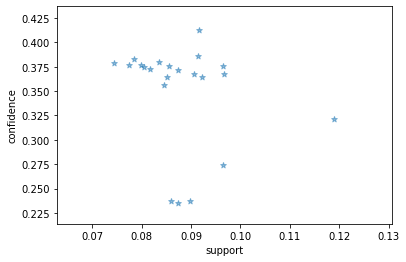

In [34]:
for i in range (len(support)):
    support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
    confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [35]:
def draw_graph(rules, rules_to_show):
 
    G1 = nx.DiGraph()
   
    colors = np.random.rand(22)  
    dic = dict()
    at =  rules['antecedents'].to_list()
    cs = rules['consequents'].to_list()
    weights = rules['lift'].to_list()
    for i in range(rules_to_show):
       
        for a in at[i]:
            if a not in dic:
                dic[a] = 90
            else:
                dic[a] +=10
            G1.add_nodes_from([a])
           
        for c in cs[i]:
           
            G1.add_edge(a, c, color='black',  weight=weights[i]*10)
    color_map = []      
   
    for i in G1.nodes():
        if i in dic:
            color_map.append(dic[i])
        else:
            color_map.append(50)
    plt.figure(figsize = (18,18))
    nx.draw_shell(G1,node_color = color_map,with_labels = True)            
        
  
    

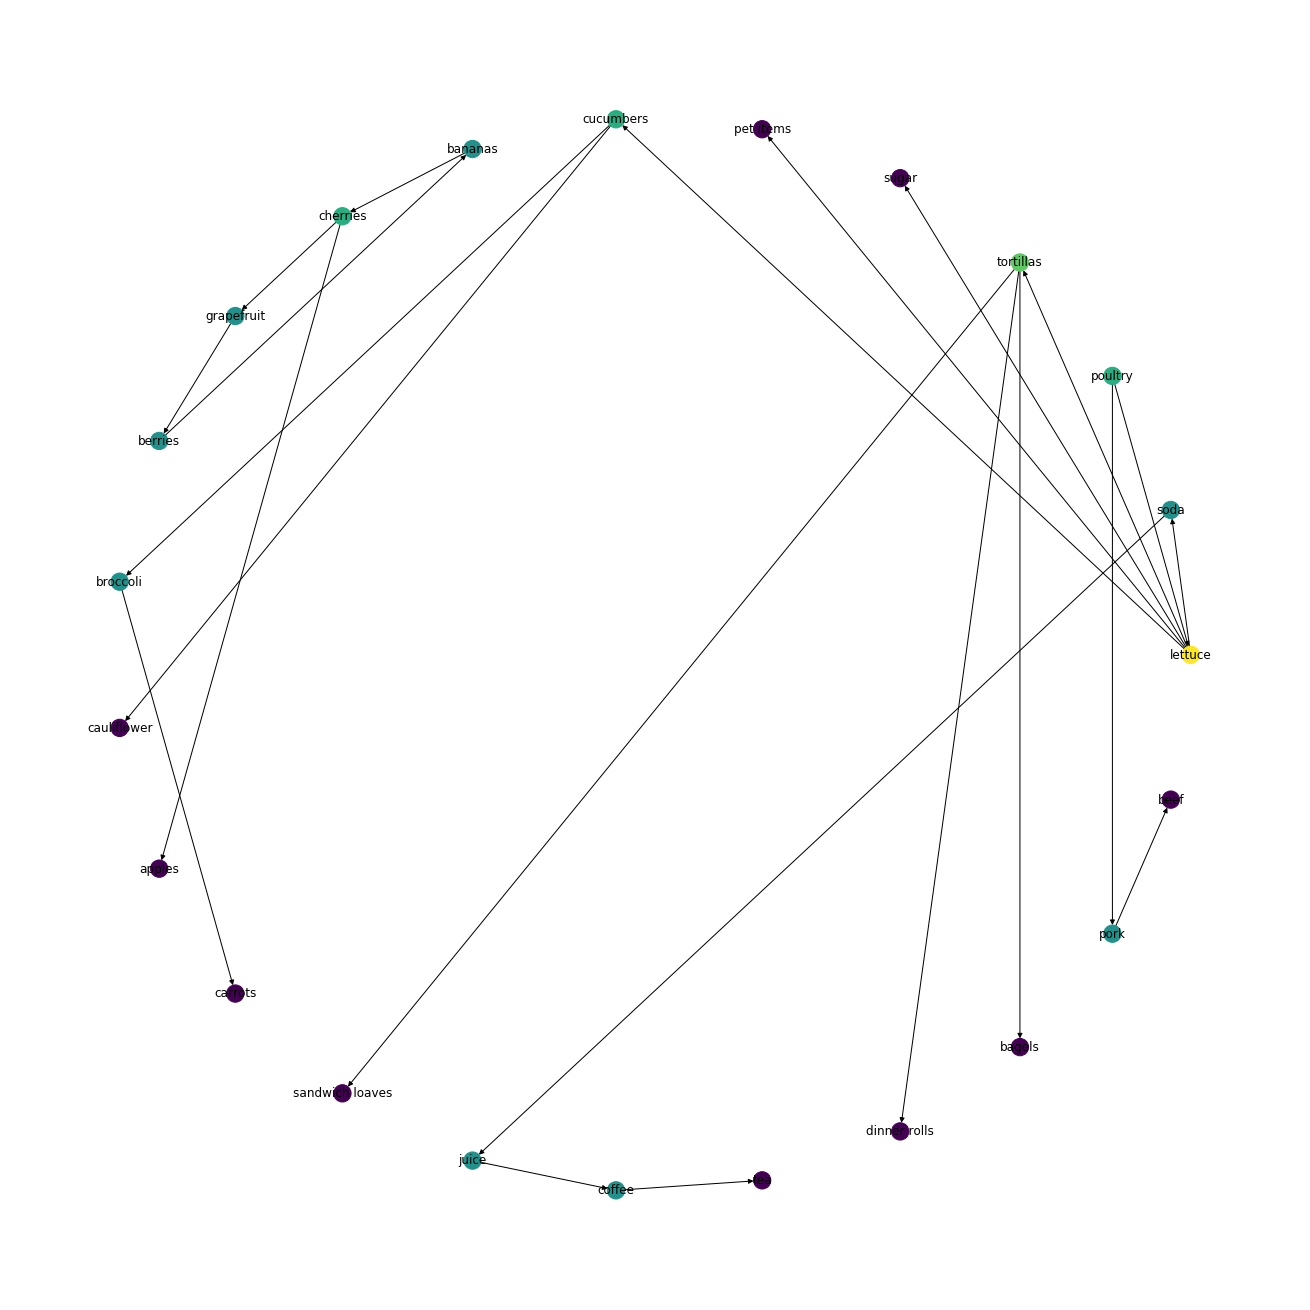

In [36]:
draw_graph(final_rules,22)

# From the node graph, we can know that 
- Category 1: berries, grapefruit, cherries, apples and bananas
- Category 2: cucumbers, broccoli, carrots, califlower 
- Category 3: tortillas, sandwish loaves, dinner rolls, bagels
- Category 4: juice, coffee, tea, soda
- category 5: pork, poultry, beef,lettuce
- Category 6: pet items, sugar
- Category 7: things that do not have a significant relationship

# To improve the categories to cover more items, cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.


# KMeans

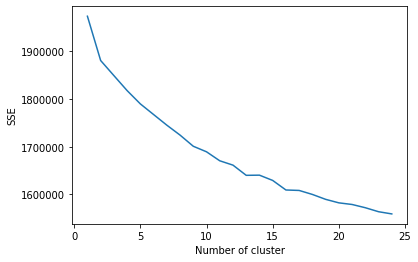

In [37]:
sse = {}
data = pivot_table.drop(columns=['order_id'])
sc_X= StandardScaler()
data_1= sc_X.fit_transform(data)
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k,init='k-means++').fit(data_1)
   
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# we can see that there is no sign for convergence and even if it has, it is too large compared to 48. Grocery stores may not want a situation like 20 categories and 2 items in each category. We can try to use pca.

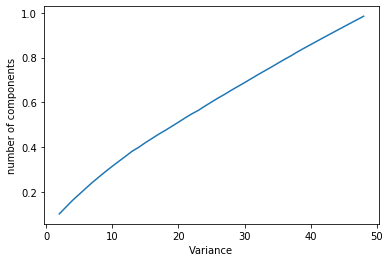

In [38]:
variance = {}

for i in range(2,49):
   
    pca=PCA(n_components=i ).fit(data_1)
    variance[i] = sum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(list(variance.keys()), list(variance.values()))
plt.xlabel("Variance")
plt.ylabel("number of components")
plt.show()

# this may be caused by the problem of sparse matrix.

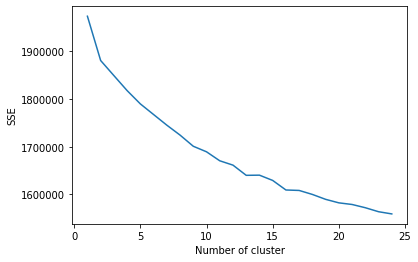

In [39]:
sse_p ={}
for i in range(2,20):
    pca = PCA().fit_transform(data)
    km = KMeans(n_clusters = i).fit(pca)
    sse_p[i] = km.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()    

# from the plot we can see 8 categories would be a fair choice

In [40]:
dis ={}
labels = {}

agg = DBSCAN(eps = 3).fit(data_1)
   


In [41]:
print(set(agg.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, -1}


In [ ]:
category = []

In [ ]:

for i in l.index:
    category.append(table_t[table_t[i] == l[i] ]['clusters7'].values[0])

In [ ]:
set(category)

In [ ]:
l['sugar']

In [ ]:
data.head()

In [43]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets[(frequent_itemsets['length'] >1) &
                   (frequent_itemsets['support'] >= 0.07)]

,support,itemsets,length
45,0.104018,"(lettuce, sugar)",2
46,0.112732,"(carrots, lettuce)",2
47,0.083701,"(carrots, cucumbers)",2
48,0.083523,"(broccoli, carrots)",2
49,0.082789,"(carrots, cauliflower)",2
50,0.089933,"(bagels, lettuce)",2
51,0.084917,"(tortillas, bagels)",2
52,0.081547,"(bagels, dinner rolls)",2
53,0.081902,"(sandwich loaves, bagels)",2
54,0.089983,"(lettuce, beef)",2


In [ ]:
dic = {}
for i in de_rules['antecedents'].unique():
    
    dic[i] = reduce(frozenset.union, de_rules[de_rules['antecedents']== i]['consequents'])

In [ ]:
dic

In [47]:
l = []
fi = frequent_itemsets.sort_values(by = 'support')['itemsets'].to_list()


In [80]:
len(fi)

98

In [93]:
leng = len(fi)
idx = 0
idxs = [0]
com = []
count = 0
for i in range(leng):
    cmp = frozenset()
    for m in range(i+1,leng):
        
    
        t = fi[i].union(fi[m])
       
        if len(t) < len(fi[i]) +len(fi[m]):
            cmp=cmp.union(t)
            count +=1
           
        else: 
            continue
    if count >leng-1:
        break
    if len(cmp):
        
        com.append(cmp)
        
    if not cmp:
       
        com.append(fi[i])

In [95]:
set(com)

{frozenset({'baby items'}),
 frozenset({'dinner rolls', 'lettuce', 'sandwich loaves', 'tortillas'}),
 frozenset({'waffles'}),
 frozenset({'coffee', 'juice', 'lettuce', 'soda', 'tea'}),
 frozenset({'shampoo'}),
 frozenset({'bagels',
            'dinner rolls',
            'lettuce',
            'sandwich loaves',
            'tortillas'}),
 frozenset({'broccoli', 'carrots', 'cauliflower', 'cucumbers', 'lettuce'}),
 frozenset({'apples',
            'bananas',
            'berries',
            'cherries',
            'grapefruit',
            'lettuce'})}

In [62]:
cmp = frozenset()
c = frozenset('atrtr')
c,cmp

(frozenset({'a', 'r', 't'}), frozenset())

In [63]:
c.union(cmp)

frozenset({'a', 'r', 't'})

In [64]:
cmp.union(c)

frozenset({'a', 'r', 't'})

In [73]:
cmp

frozenset()